# K-Nearest Neighbor (k-NN) Classification 

In this notebook, we explore an example of a <b>non-parametric</b> model for classification in a supervised learning context, namely the <b>k-nearest neighbor (k-NN)</b> classifier. Parametric models of the unconditional $p(y \,|\, \boldsymbol{\theta})$ or conditional form $p(y \,|\, \mathbf{x}, \boldsymbol{\theta})$ are either provided parameters $\boldsymbol{\theta} \in \mathbb{R}^n$ or derive them via model fitting on some dataset $\mathcal{D}$. On the other hand, non-parametric models make no assumption about the underlying distribution of the data $\mathcal{D}$, and are free to learn any functional approximation over the data.

In [1]:
# Widget to manipulate plots in Jupyter notebooks
%matplotlib widget 

import matplotlib.pyplot as plt # For general plotting
from matplotlib.ticker import MaxNLocator

import numpy as np

from scipy.spatial.distance import cdist
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier as KNN

np.set_printoptions(suppress=True)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=22)   # fontsize of the figure title

random_state = 7
np.random.seed(random_state)

## Dataset Generation

Before describing the k-NN classification method, let's first define a dataset $\mathcal{D} = \{(\mathbf{x}^{(i)}, y^{(i)}) \}_{i=1}^N$ with two-dimensional inputs $\mathbf{x}\in\mathbb{R}^2$ and three classes $y \in \{0, 1, 2\}$ over which we will apply our non-parametric classifier. In particular, we will use sklearn's [make_blobs](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html) helper routine from the `datasets` module to generate our data, while also splitting it into a training and test set:

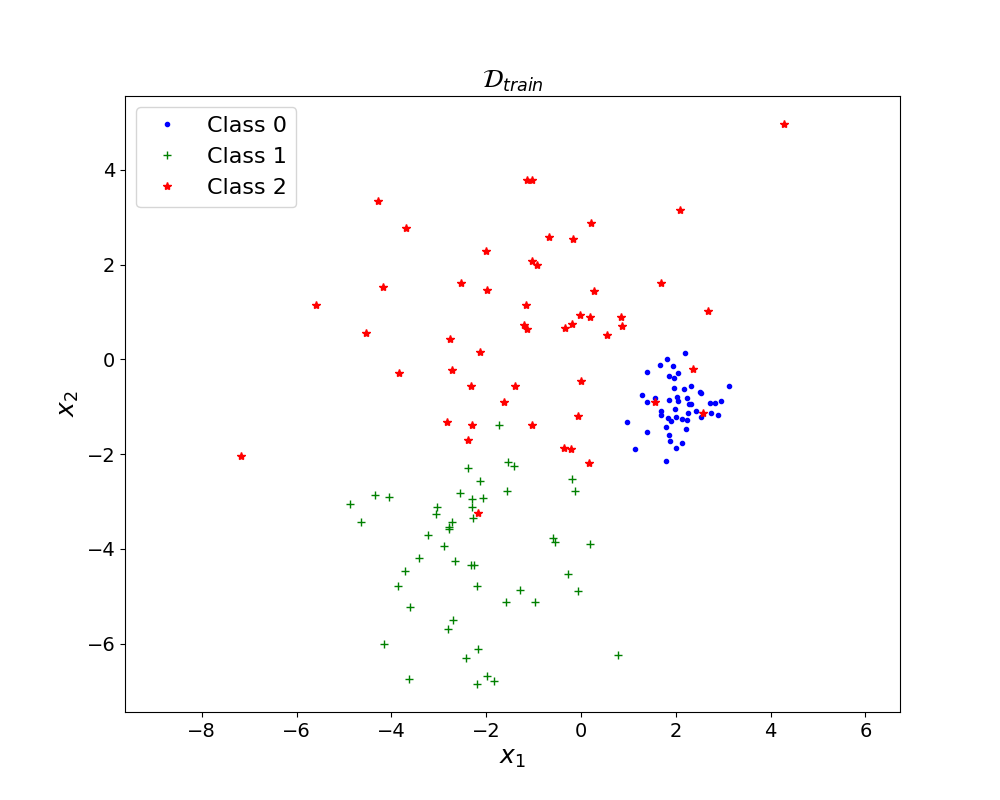

In [2]:
# Helper import to generate the Gaussian data "blobs"
from sklearn.datasets import make_blobs

# Follow a 75:25 split into training:test
N = 200
N_train = int(N*0.75)
# Generating three Gaussian blobs with two-dimensional samples and different variances
centers = [[2, -1], [-2, -4], [-1, 1]]
X, y = make_blobs(n_samples=N, n_features=2, centers=centers, cluster_std=[0.5, 1.5, 2.0], random_state=random_state)
X_train = X[:N_train]
y_train = y[:N_train]
X_test = X[N_train:]
y_test = y[N_train:]

# Convenience strings for plotting
markers = '.+*'
colors = 'bgr'
# Grab the unique labels in 'y'
y_unique = np.unique(y)

plt.figure(figsize=(10, 8))
for i in range(len(y_unique)):
    plt.plot(X_train[y_train==y_unique[i], 0], X_train[y_train==y_unique[i], 1], 
             markers[i] + colors[i], label="Class " + str(y_unique[i]))

plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title(r"$\mathcal{D}_{train}$")
plt.legend()
plt.axis('equal')
plt.show()

## The Algorithm

A summary of how the k-NN algorithm classifies a test input, $\mathbf{x}_{test}$, is as follows. First, find the set of $k$ closest training examples in  $\mathcal{D}_{train}$ to this test input. These <b>nearest neighbors</b> are denoted as $N_k(\mathbf{x}_{test}, \mathcal{D}_{train})$. Then examine the labels of these nearest neighbors to obtain a distribution of labels for the local region surrounding $\mathbf{x}_{test}$:

$$ p(y=c \, | \, \mathbf{x}_{test}, \mathcal{D}_{train}) = \frac{1}{k}\sum_{i \in N_k(\mathbf{x}_{test}, \mathcal{D}_{train})} \mathbb{I} (y^{(i)} = c),$$

where $\mathbb{I}(e)$ is a binary [indicator function](https://en.wikipedia.org/wiki/Indicator_function), also sometimes written as $\mathbf{1}(e)$, which returns 1 if the boolean condition $e$ is true, and 0 otherwise. Another common way of predicting the output $\hat{y}$ for $\mathbf{x}_{test}$ is to return the <b>majority label</b>:

$$ \hat{y} = \text{mode} \left(\{y^{(i)} : (\mathbf{x}^{(i)}, y^{(i)}) \in N_k(\mathbf{x}_{test}, \mathcal{D}_{train}) \} \right).$$

k-NN classification falls under the category of [instance-based learning](https://en.wikipedia.org/wiki/Instance-based_learning) (or <b>exemplar-/memory-based</b>), where training instances are stored in memory for classification. Therefore, <i>learning</i> amounts to storing training data for comparison against new instances at test time, hence the $\mathcal{D}_{train}$ argument in the $N_k(\mathbf{x}_{test}, \mathcal{D}_{train})$ function. These methods are often referred to as "lazy" (as opposed to "eager") due to the fact that the training data is only processed for generalization to test data when a new instance is encountered.

Key to the idea of comparing a test input, $\mathbf{x}_{test}$, against each of the training inputs $\mathbf{x}^{(i)}$ in $\mathcal{D}_{train}$, is the notion of <b>similarity</b> or dissimilarity. For many instace-based models, a distance function $d(\mathbf{x}, \mathbf{x}')$ serves to define this dissimilarity between two arbitrary data instances. It is common in the k-NN algorithm to use the [Minkowski distance](https://en.wikipedia.org/wiki/Minkowski_distance):

$$d(\mathbf{x}, \mathbf{x}') = \left( \sum_{j=1}^n | \mathbf{x}_j - \mathbf{x}_j' |^p \right)^{\frac{1}{p}},$$

with the $p=2$ and $p=1$ cases specifying the Euclidean and Manhattan distances, respectively. Another common choice is the [Mahalanobis distance](https://en.wikipedia.org/wiki/Mahalanobis_distance):

$$d(\mathbf{x}, \mathbf{x}') = \sqrt{(\mathbf{x} - \mathbf{x}')^\intercal \mathbf{C} (\mathbf{x} - \mathbf{x}')},$$

with positive-definite sample covariance matrix $\mathbf{C}$.

The below code snippet creates a mesh grid of test samples within the range of the data distribution, and shows how to compute distances between each test input, $\mathbf{x}_{test}$, and the training samples $\mathbf{x}^{(i)} \in \mathcal{D}_{train}$:

In [3]:
# Generate a 200x200 grid of test samples that spans the full range of the training data 
x_bounds = np.linspace(np.floor(np.min(X_train[:,0])), np.ceil(np.max(X_train[:,0])), 200)
y_bounds = np.linspace(np.floor(np.min(X_train[:,1])), np.ceil(np.max(X_train[:,1])), 200)
xx, yy = np.meshgrid(x_bounds, y_bounds)
# Flattening grid and concatenating
xy = np.c_[xx.ravel(), yy.ravel()]

# Compute pairwise distance matrix between grid test points and the training data
# dist[i, j] is the Euclidean distance between new sample xy[i] and training instance X_train[j]
dist = cdist(xy, X_train, metric='euclidean')

# Could also use Manhattan distance: 
# dist = cdist(xy, X_train, metric='cityblock')
# Or equivalently:
# dist = cdist(xy, X_train, metric='minkowski', p=1)

# Limiting case of Minkowski distance, p->infinity, i.e. the L-Infinity norm:
# dist = cdist(xy, X_train, metric='chebyshev') 

# Mahalanobis distance metric:
# dist = cdist(xy, X_train, metric='mahalanobis')

There are two hyperparameters to consider when applying the k-NN algorithm: size of the neighborhood, $k$, and the distance metric, $d(\mathbf{x}, \mathbf{x}')$. We can use cross-validation or a validation split to select these hyperparameters (recall the [polynomial regression example](../linear_regression/ls_polynomial_reg_cv.ipynb)).

However, let's next simply evaluate the nearest neighbors $N_k(\mathbf{x}_{test}, \mathcal{D}_{train})$ by assuming the Euclidean distance function and looking at three values for $k=\{1, 3, 5\}$. Note that the following code will make use of the [np.argpartition](https://numpy.org/doc/stable/reference/generated/numpy.argpartition.html) function to perform a sorted partitioning of the $d(\mathbf{x}, \mathbf{x}')$ matrix (sorted in ascending order), and then extract the $k$ nearest neighbor indices from the result. Predictions will be made based on the majority label of the neighboring samples:

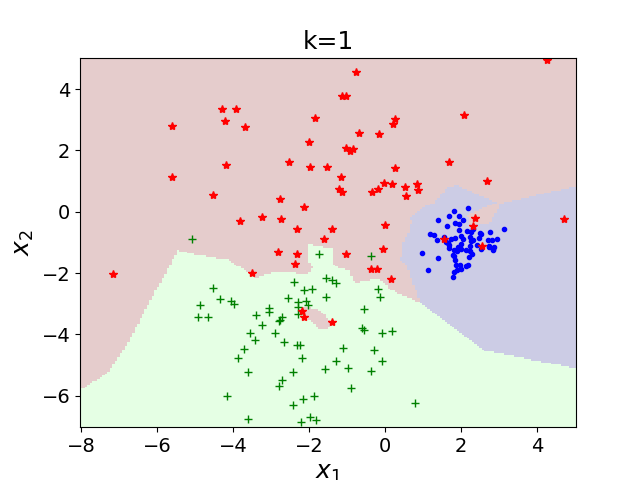

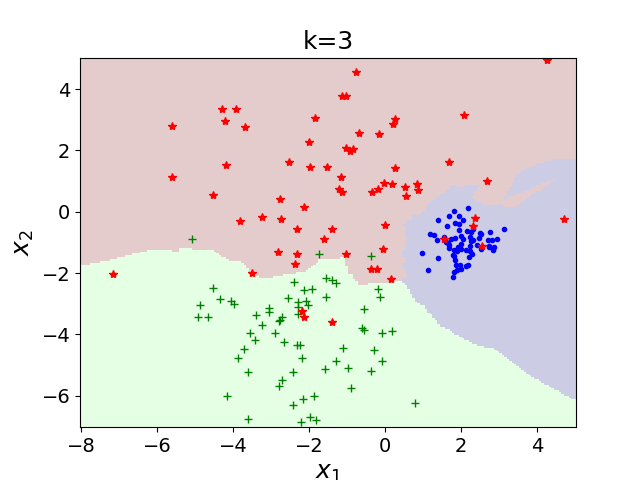

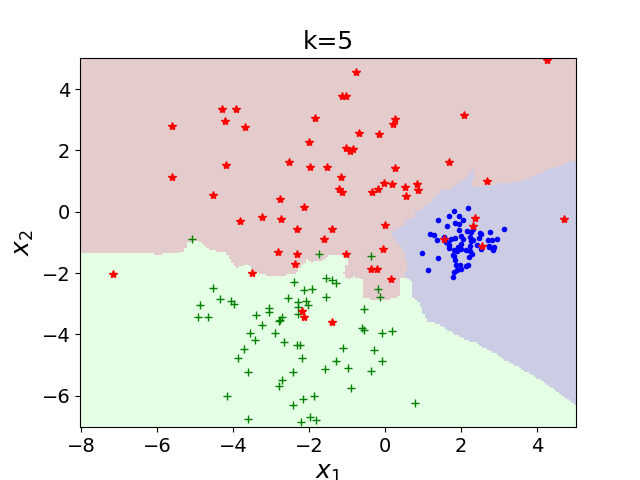

In [4]:
for k in [1, 3, 5]:
    plt.figure()
    # Return the indices of the k closest distances, shaped [200x200,k]
    k_smallest_indices = np.argpartition(dist, k-1)[:, :k]
    # Labels associated with the k nearest neighbors (matches shape of k_smallest_indices)
    k_labels = y_train[k_smallest_indices]
    # Find the majority label from the k neighbors to the grid samples, shaped [200x200,1]
    y_predicted = np.apply_along_axis(lambda x: np.bincount(x).argmax(), 1, k_labels)
    
    # Colored mesh grid plot using the 'jet' map, which aligns with BGR labeling scheme for our 3 classes
    plt.pcolormesh(xx, yy, y_predicted.reshape(200, 200), cmap="jet", alpha=0.2)
    for i in range(len(y_unique)):
        plt.plot(X[y==y_unique[i], 0], X[y==y_unique[i], 1], markers[i] + colors[i], label="Class " + str(y_unique[i]))
    
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$")
    plt.title("k=%s" % (k))
    plt.show()

## Test Set Performance

The above plots illustrate different "decision boundaries" induced by the k-NN classifier when applied to the rectangular grid of samples, but how should we judge performance according to our choice of $k$? Let's examine classification accuracy for varying values of $k$ on both the training and test sets:

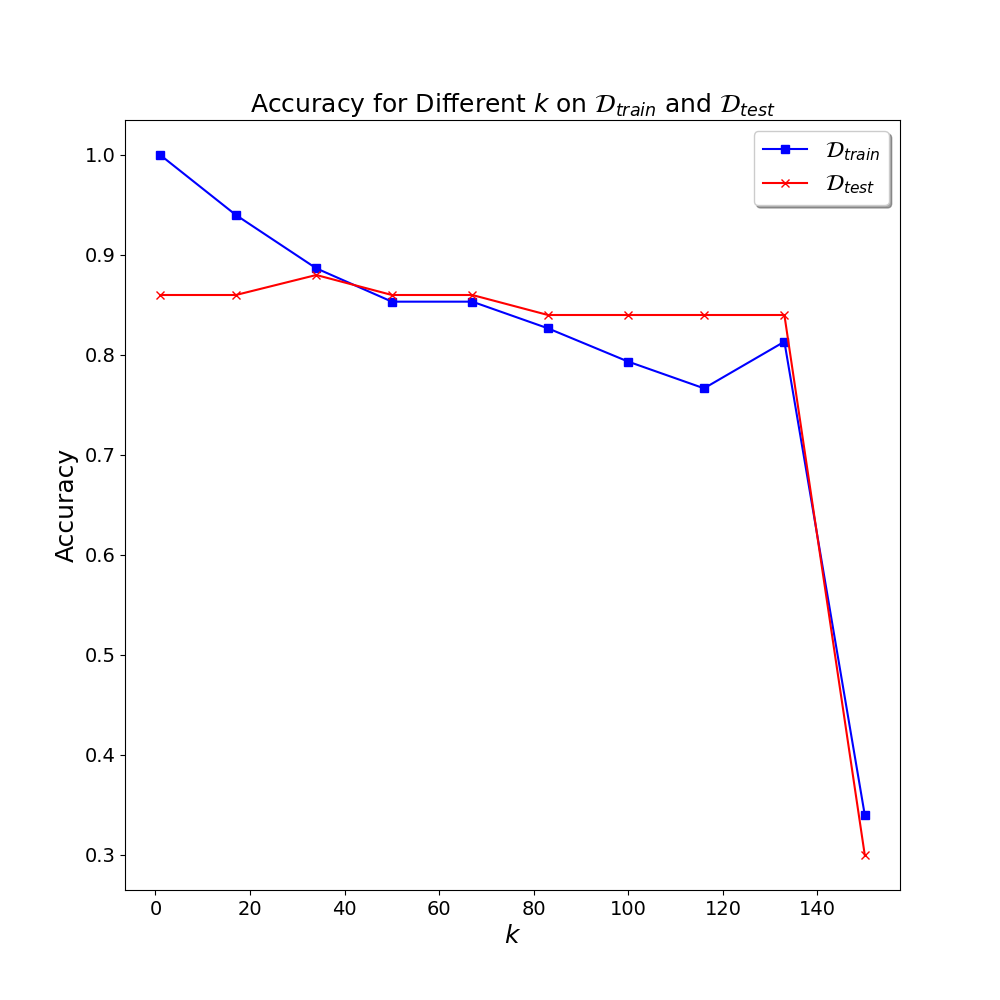

In [5]:
# Compute pairwise distance matrix for training and test samples
dist_train = cdist(X_train, X_train, metric='euclidean')
dist_test = cdist(X_test, X_train, metric='euclidean')

# List of k values
k_list = [int(x) for x in np.linspace(1, N_train, 10)]
# List of training & test accuracies, depending on k
train_acc = []
test_acc = []
for k in k_list:
    k_indices_train = np.argpartition(dist_train, k-1)[:, :k]
    k_indices_test = np.argpartition(dist_test, k-1)[:, :k]

    # Find the majority label from the k neighbors
    y_predicted_train = np.apply_along_axis(lambda x: np.bincount(x).argmax(), 1, y_train[k_indices_train])
    y_predicted_test = np.apply_along_axis(lambda x: np.bincount(x).argmax(), 1, y_train[k_indices_test])
    
    # Append accuracy scores for this k value
    train_acc.append(accuracy_score(y_train, y_predicted_train))
    test_acc.append(accuracy_score(y_test, y_predicted_test))

# Plot accuracy vs k
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(k_list, train_acc, color="b", marker="s", label=r"$\mathcal{D}_{train}$")
ax.plot(k_list, test_acc, color="r", marker="x", label=r"$\mathcal{D}_{test}$")

# Force x-axis for k to be integer
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.legend(loc='upper right', shadow=True)
plt.xlabel(r"$k$")
plt.ylabel("Accuracy")
plt.title(r"Accuracy for Different $k$ on $\mathcal{D}_{train}$ and $\mathcal{D}_{test}$")
plt.show()

Observe how for $k=1$, there is no training error and we are severely <b>overfitting</b> the training set. This is obvious when evaluating on $\mathcal{D}_{train}$ as every new sample is already stored in memory, therefore the 1-NN classifier will always choose the same sample as its nearest neighbor and never make a mistake on the correct label to predict. When $k=1$, the k-NN classifier produces a [Voronoi diagram](https://en.wikipedia.org/wiki/Voronoi_diagram) of the points, such that each Voronoi cell in the partitioned space is associated with exactly one sample $\mathbf{x}^{(i)}$. Boundaries drawn around the polygon cells will depend on the distance metric $d(\mathbf{x}, \mathbf{x}')$ utilized.

### Extra Notes

- Larger $k$ may sometimes perform better, where roughly $k \approx 30$ yields the best test set performance in the example above. Another rule of thumb is to set $k < \sqrt{N}$. Ofcourse, a more systematic way of selecting $k$ and $d(\mathbf{x}, \mathbf{x}')$ is via cross-validation or by using a separate validation set.
- What happens when $k=N$? The most common label in $\mathcal{D}_{train}$ will always be predicted, independent of the test sample. This is equivalent to using a <b>constant classifier</b>.
- The main assumption made by the k-NN algorithm is that similar inputs will have similar outputs. If this assumption of "similarity" or closeness does not hold, then the algorithm breaks (<b>curse of dimensionality</b>, as $n >> 0$, almost the entire volume of the data space is needed to find the nearest neighbors).

### Limitations

The k-NN classifier is simple and effective, especially when the distance metric reliably reflects some notion of dissimilarity in the data space, and the dimensionality of the data $n$ is sufficiently small. Yet, there are a few major limitations to the algorithm:

- The main problem is the curse of dimensionality. For higher input dimensionality, $n$, the volume of the data space grows exponentially, and the data points stop being similar to each other based on distance. The idea of "local" or "neighboring" regions no longer applies.
- Another issue is that the k-NN algorithm stores the entire training set $\mathcal{D}_{train}$ for prediction. This is very wasteful of storage space, and will only worsen for larger $N$, despite the improvements in accuracy as $N \rightarrow \infty$.
- "Training" a k-NN takes $O(1)$ time, but prediction is computationally expensive. To find the $k$ nearest neighbors by computing the distance to all $N$ training examples for a single test sample, $\mathbf{x}_{test} \in \mathbb{R}^n$, has a time complexity of $O(knN)$, which becomes intractable when $n > 10$.

Nevertheless, there are numerous techniques to mitigate these limitations. For instance, one can use a metric that works with only a <b>subset</b> of the dimensions, e.g., by learning a metric that computes distances in a low-dimensional embedding/latent space, rather than in the original data space. One may also perform an efficient exact search for the nearest neighbors by using faster data structures to partition the search space, e.g., [k-d trees](https://en.wikipedia.org/wiki/K-d_tree). Alternatively, hashing methods, e.g., [locality-sensitive hashing](https://en.wikipedia.org/wiki/Locality-sensitive_hashing), can be applied to approximate the nearest neighbor search. A final practical trick could be to try pre-processing your data, e.g., by removing redundant (irrelevant, correlated) attributes, which will improve both computational efficiency and storage requirements for $\mathcal{D}_{train}$.


There are many open-source libraries, such as [Faiss](https://github.com/facebookresearch/faiss), to help you implement solutions for the aforementioned k-NN limitations. For this notebook, we will simply illustrate how to use the common `scikit-learn` framework, as it addresses some of the above techniques for improving [nearest neighbor algorithms](https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbor-algorithms).

## Scikit-Learn API

The [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) class offers an easy-to-use API with more efficient algorithm implementations (e.g. k-d tree structures), depending on the dataset provided. Below is a brief demonstration:

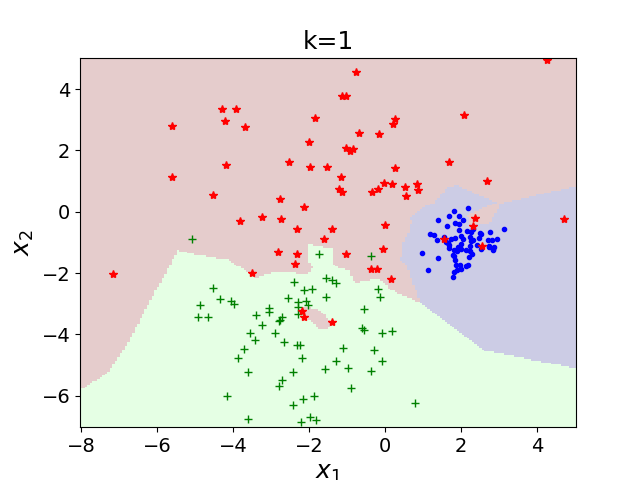

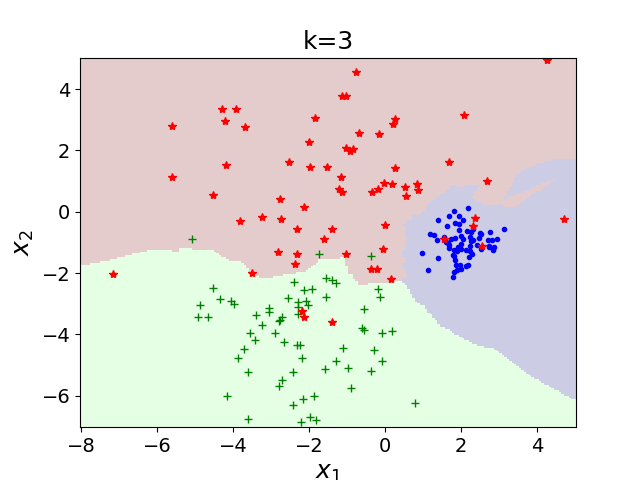

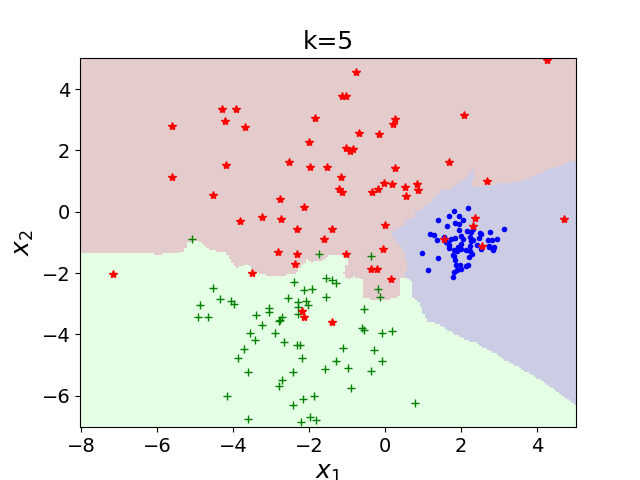

In [6]:
# "Train" a k-NN classifier and use it to predict on the training set for different values of k
for k in [1, 3, 5]:
    plt.figure()
    # Using the default "auto" algorithm with the p=2 Minkowski distance metric, i.e. Euclidean distance 
    # "auto" examines the training data and attempts to select the best algorithm, e.g. brute-force vs k-d trees
    knn = KNN(n_neighbors=k, algorithm='auto', p=2, metric='minkowski')
    knn.fit(X_train, y_train)
    
    # xy from the rectangular grid samples defined earlier
    y_predicted = knn.predict(xy)

    plt.pcolormesh(xx, yy, y_predicted.reshape(200, 200), cmap="jet", alpha=0.2)
    for i in range(len(y_unique)):
        plt.plot(X[y==y_unique[i], 0], X[y==y_unique[i], 1], markers[i] + colors[i], label="Class " + str(y_unique[i]))
    
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$")
    plt.title("k=%s" % (k))
    plt.show()

## References

Code adapted from <i>"knn_classify_demo.ipynb"</i> at:

@book{pml1Book,<br>
&emsp; author = "Kevin P. Murphy",<br>
&emsp; title = "Probabilistic Machine Learning: An introduction",<br>
&emsp; publisher = "MIT Press",<br>
&emsp; year = 2022,<br>
&emsp; url = "probml.ai"<br>
}